<a href="https://colab.research.google.com/github/geroalbornoz/markets/blob/master/Trading_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trading Algorítmico Usando diferentes estrategias:

. de 3 medias móviles exponenciales

. MACD

. bollinger bands

. Money flow Index (MFI)

. de Doble Media Móvil Exponencial (DEMA)

. Stan Weinstein (con EMA, no WMA)

. Relative Strentgh Index (RSI)


Link del canal origen de los tutoriales:

https://www.youtube.com/watch?v=SEQbb8w7VTw&t=973s


Apéndice: Análisis de la Acción
. Estadística Descriptiva
. Retornos
. Precios Promedio
. Precios Máximos y Mínimos 

Link de referencia:

https://www.quantconnect.com/tutorials/introduction-to-financial-python/pandas-resampling-and-dataframe#Pandas-Resampling-and-DataFrame-Resampling

In [229]:
pip install yfinance

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [231]:
#ELEGIMOS EL ACTIVO (CAMBIANDO EL TICKER PODÉS ANALIZAR LA ACCIÓN QUE QUIERAS)
asset = "GGAL" #"^MERV"
ticker = yf.Ticker(asset)
period_asset = "ytd"
# get historical market data
hist = ticker.history(period=period_asset)

#print(hist)

In [232]:
#Armar el dataset
df = pd.DataFrame(hist)



In [233]:
#df.info() 

In [234]:
#hacer que el índice tenga nombre de columna
df.index.name = "Date"
#df.head()

In [235]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [236]:
fig = go.Figure(
    data = [go.Candlestick(x= df.index, 
                           low = df["Low"], 
                           high= df["High"], 
                           open=df["Open"], 
                           close=df["Close"],
                           increasing_line_color = "green",
                           decreasing_line_color = "red")
    ]
    )
fig.update_layout(xaxis_rangeslider_visible=False,
                   title="Precio de Cierre de {}".format(asset),
                  yaxis_title='Precio',)
fig.show()

In [237]:
#Gráfico del Close Price
"""
plt.figure(figsize=(22,10), clear= False, facecolor="y")
plt.title("Precio de Cierre", fontsize = 24)
plt.plot(df["Close"])
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.show()
"""

'\nplt.figure(figsize=(22,10), clear= False, facecolor="y")\nplt.title("Precio de Cierre", fontsize = 24)\nplt.plot(df["Close"])\nplt.xlabel("Fecha", fontsize = 18)\nplt.ylabel("Precio", fontsize = 18)\nplt.xticks(rotation=45)\nplt.show()\n'

**Estrategia de 3 Medias Móviles**

In [238]:
#Calcular 3 medias móviles 
#Rápida: EMA
short = 5
ShortEMA = df.Close.ewm(span=short, adjust = False).mean()

#Larga: EMA
long = 20
LongEMA = df.Close.ewm(span=long, adjust = False).mean()

#Intermedia: EMA
middle = 8
MiddleEMA = df["Close"].ewm(span=middle, adjust = False).mean()

#200
longest = 200
MA200 = df["Close"].rolling(window=longest).mean()



In [240]:
df["Short"] = ShortEMA
df["Middle"] = MiddleEMA
df["Long"] = LongEMA
df["MA200"] = MA200
#df.tail()

In [241]:
#Crear la función para comprar y vernder con 3 EMAS
def buy_sell_function(data):

  buy_list = []
  sell_list = []
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data["Middle"][i] > data["Long"][i] and data["Short"][i] > data["Middle"][i] and flag_long == False:
      buy_list.append(data["Close"][i])
      sell_list.append(np.nan)
      flag_long = True
      flag_short = False

    elif data["Middle"][i] < data["Long"][i] and data["Short"][i] < data["Middle"][i] and flag_short == False:
      sell_list.append(data["Close"][i])
      buy_list.append(np.nan)
      flag_short = True
      flag_long = False

    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)

  return (buy_list, sell_list)



In [242]:
#Add the buy and sell signals to the data
df["Buy"] = buy_sell_function(df)[0]
df["Sell"] = buy_sell_function(df)[1]

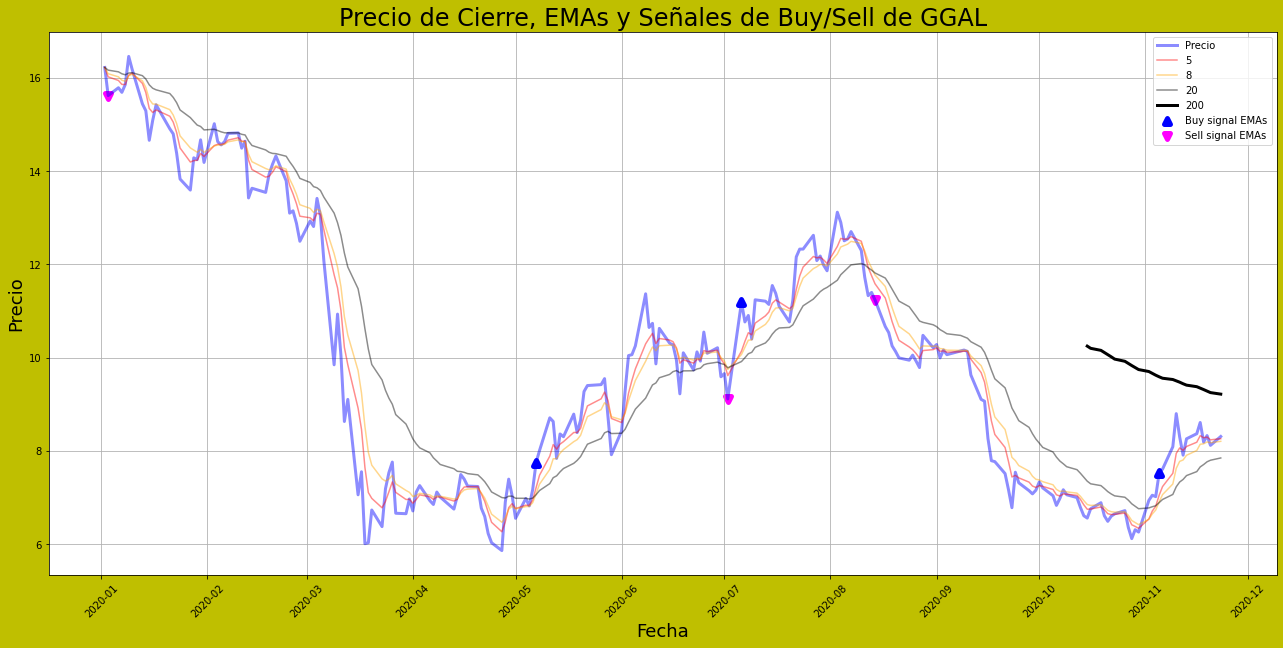

In [243]:
#Gráfico del Close Price, las EMA y las señales
plt.figure(figsize=(22,10), clear= False, facecolor="y")
plt.title("Precio de Cierre, EMAs y Señales de Buy/Sell de {}".format(asset), fontsize = 24)
plt.plot(df["Close"], label = "Precio", color = "blue", alpha = 0.45,lw = 3 )
plt.plot(ShortEMA, label = short, color = "red", alpha = 0.45)
plt.plot(MiddleEMA, label = middle, color = "orange", alpha = 0.45)
plt.plot(LongEMA, label = long, color = "black", alpha = 0.45)
plt.plot(MA200, label = longest, color = "black", lw=3)
plt.scatter(df.index, df["Buy"], color = "blue", marker = "^", alpha = 1,label = "Buy signal EMAs",lw = 5 )
plt.scatter(df.index, df["Sell"], color = "magenta", marker = "v", alpha = 1, label = "Sell signal EMAs",lw = 5)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis ='both')
plt.show(block= True)

**Estrategia de DEMAs**

In [244]:
#Create the function to calculate the Double Exponential Moving Average (DEMA)

def DEMA(data, time_period, column):
  EMA = data[column].ewm(span=time_period, adjust=False).mean() #Calculate the EMA for some period
  DEMA = 2 * EMA - EMA.ewm(span=time_period, adjust=False).mean() #Calculate the DEMA
  return DEMA

In [245]:
#Guardar las DEMAs en el df
df["DEMA_{}".format(short)] = DEMA(df, short, "Close")
df["DEMA_{}".format(long)] = DEMA(df, long, "Close")

In [246]:
#Create the buy/sell function DEMA
def DEMA_strategy(data):
  buy_list = []
  sell_list = []
  flag = False
  #Loop through the data
  for i in range(len(data)):
    if data["DEMA_{}".format(short)][i] > data["DEMA_{}".format(long)][i] and flag == False:
      buy_list.append(data["Close"][i])
      sell_list.append(np.nan)
      flag = True
    elif data["DEMA_{}".format(short)][i] < data["DEMA_{}".format(long)][i] and flag == True:
      sell_list.append(data["Close"][i])
      buy_list.append(np.nan)
      flag = False
    else:
      buy_list.append(np.nan)      
      sell_list.append(np.nan)

  #Esta función también mete las señales en el data set
  data["Buy_DEMA"] = buy_list
  data["Sell_DEMA"] = sell_list

In [247]:
#Run the strategy
DEMA_strategy(df)

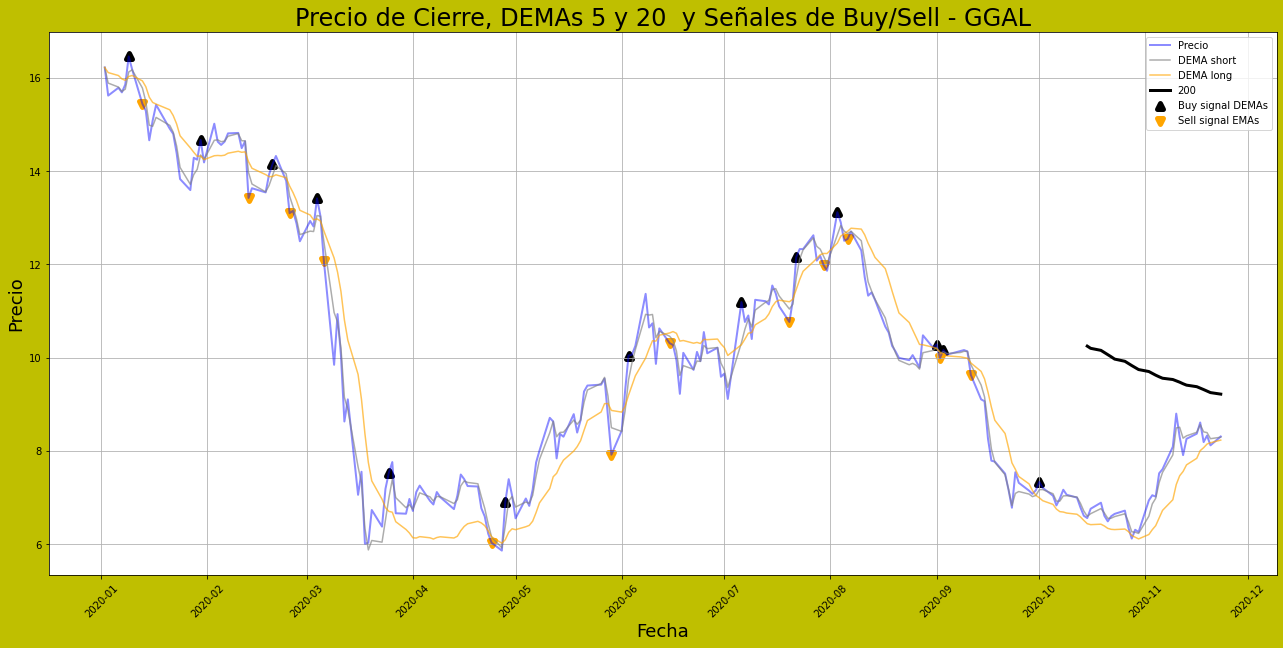

In [248]:
#Gráfico del Close Price, las DEMA y las señales
plt.figure(figsize=(22,10), clear= False, facecolor="y")
plt.title("Precio de Cierre, DEMAs {} y {}  y Señales de Buy/Sell - {}".format(short, long, asset), fontsize = 24)
plt.plot(df["Close"], label = "Precio", color = "blue", alpha = 0.45,lw = 2 )
plt.plot(df["DEMA_{}".format(short)], label = "DEMA short", color = "grey", alpha = 0.65)
plt.plot(df["DEMA_{}".format(long)], label = "DEMA long", color = "orange", alpha = 0.65)
plt.plot(MA200, label = longest, color = "black", lw=3)
plt.scatter(df.index, df["Buy_DEMA"], color = "black", marker = "^", alpha = 1,label = "Buy signal DEMAs",lw = 5 )
plt.scatter(df.index, df["Sell_DEMA"], color = "orange", marker = "v", alpha = 1, label = "Sell signal EMAs",lw = 5)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis ='both')
plt.show(block= True)

Algorithmic Trading Strategy Using MACD
**texto en negrita**



In [249]:
#Calcular 2 medias móviles: short y long 
#Rápida: EMA
short_MACD = 12
ShortEMA_MACD = df.Close.ewm(span=short_MACD, adjust = False).mean()

#Lenta: EMA
long_MACD = 26
LongEMA_MACD = df.Close.ewm(span=long_MACD, adjust = False).mean()

#Calcular Línea del MACD

MACD = ShortEMA_MACD - LongEMA_MACD

signal_MACD = MACD.ewm(span=9, adjust = False).mean()


In [250]:
#Agregar columnas al df
df["MACD"] = MACD
df["MACD Signal"] = signal_MACD

In [ ]:
#df.head()

In [252]:
#Función de compra venta
def buy_sell_MACD(signal):
  Buy_MACD = []
  Sell_MACD = []
  flag = -1

  for i in range(0,len(signal)):
    if signal["MACD"][i] > signal["MACD Signal"][i]:
      Sell_MACD.append(np.nan)
      if flag !=1:
        Buy_MACD.append(signal["Close"][i])
        flag = 1
      else:
        Buy_MACD.append(np.nan)     
    elif signal["MACD"][i] < signal["MACD Signal"][i]:
      Buy_MACD.append(np.nan)
      if flag !=0:
        Sell_MACD.append(signal["Close"][i])
        flag = 0
      else:
        Sell_MACD.append(np.nan)
    else:
       Sell_MACD.append(np.nan)
       Buy_MACD.append(np.nan)

  return (Buy_MACD, Sell_MACD)  

In [253]:
#Agregar columnas al df
a = buy_sell_MACD(df)
df["Buy Price MACD"] = a[0]
df["Sell Price MACD"] = a[1]


In [254]:
#df.head()

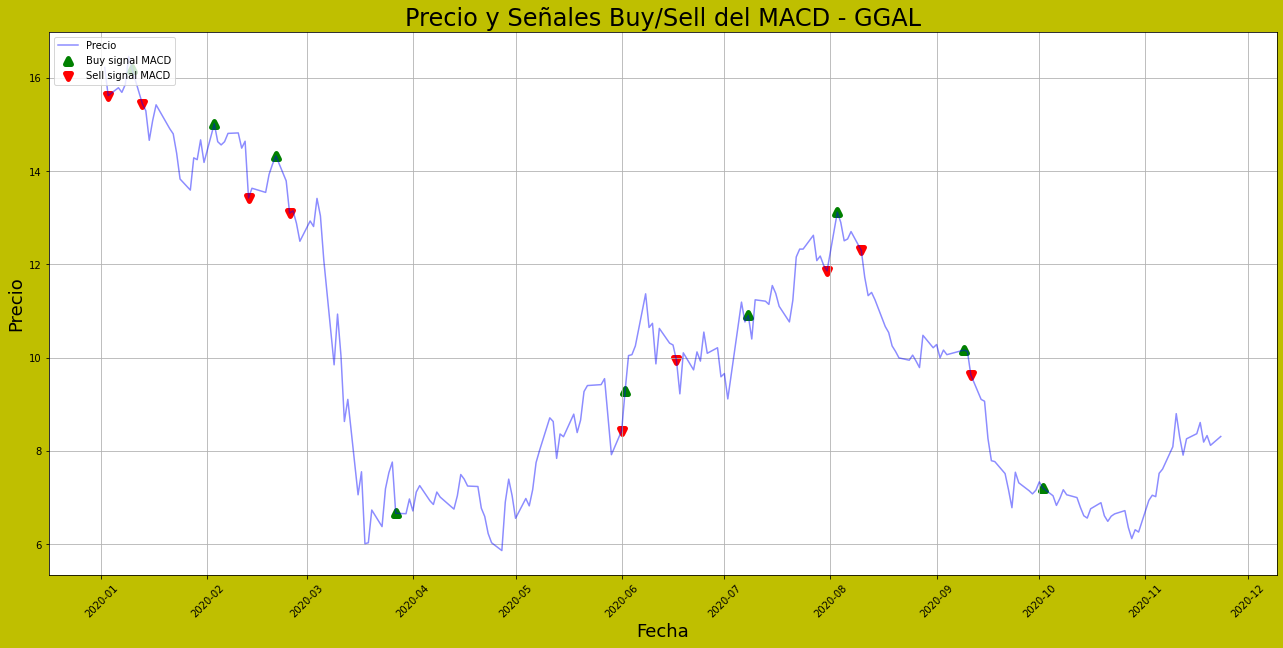

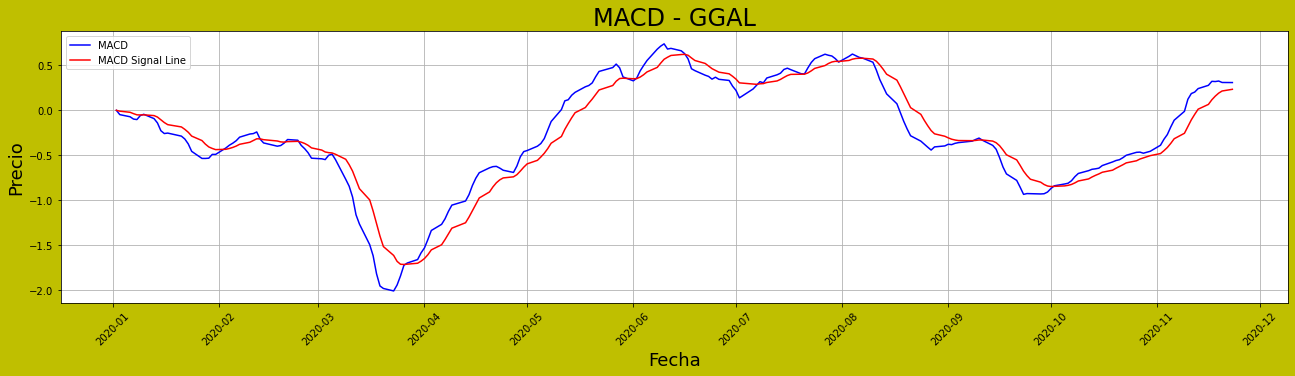

In [255]:
#Gráfico del MACD y sus señales
plt.figure(figsize=(22,10), clear= False, facecolor="y",)
plt.title("Precio y Señales Buy/Sell del MACD - {}".format(asset), fontsize = 24)
plt.scatter(df.index, df["Buy Price MACD"], color = "green", marker = "^", alpha = 1, label = "Buy signal MACD",lw = 5 )
plt.scatter(df.index, df["Sell Price MACD"], color = "red", marker = "v", alpha = 1, label = "Sell signal MACD",lw = 5 )
plt.plot(df["Close"], label = "Precio", color = "blue", alpha = 0.45)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper left")
plt.grid(axis ='both')
plt.show()

#Gráfico del MACD
plt.figure(figsize=(22,5), clear= False, facecolor="y")
plt.title("MACD - {}".format(asset), fontsize = 24)
plt.plot(df.index, MACD, label = "MACD", color = "blue", alpha = 1)
plt.plot(df.index, signal_MACD, label = "MACD Signal Line", color = "red", alpha = 1)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.grid(axis ='both')
plt.legend(loc = "upper left")
plt.show(block= True)

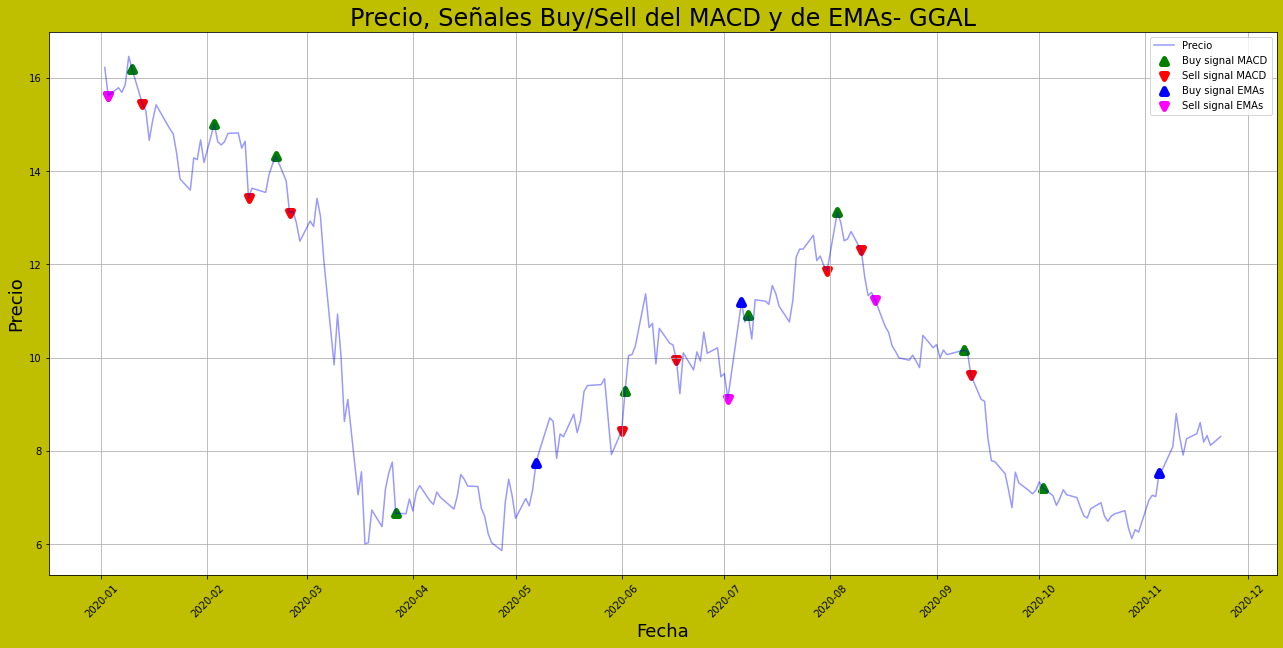

In [256]:
#Gráfico del MACD. EMAs y sus señales
plt.figure(figsize=(22,10), clear= False, facecolor="y")
plt.title("Precio, Señales Buy/Sell del MACD y de EMAs- {}".format(asset), fontsize = 24)
plt.scatter(df.index, df["Buy Price MACD"], color = "green", marker = "^", alpha = 1, label = "Buy signal MACD",lw = 5 )
plt.scatter(df.index, df["Sell Price MACD"], color = "red", marker = "v", alpha = 1, label = "Sell signal MACD",lw = 5 )
plt.scatter(df.index, df["Buy"], color = "blue", marker = "^", alpha = 1,label = "Buy signal EMAs",lw = 5 )
plt.scatter(df.index, df["Sell"], color = "magenta", marker = "v", alpha = 1, label = "Sell signal EMAs",lw = 5)
plt.plot(df["Close"], label = "Precio", color = "blue", alpha = 0.4)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.grid(axis ='both')
plt.show()

**Estrategia con Bollinger Bands**

In [257]:
#Calcular SMA, desv std y bandas upper y lower
period = 20
#SMA
df["SMA"] = df["Close"].rolling(window=period).mean()
#Desv Std
df["STD"] =  df["Close"].rolling(window=period).std()

df["Upper"] = df["SMA"] + (df["STD"] * 2) #Upper band
df["Lower"] = df["SMA"] - (df["STD"] * 2) #Lower band

column_list = ["Close", "SMA", "Upper", "Lower"]



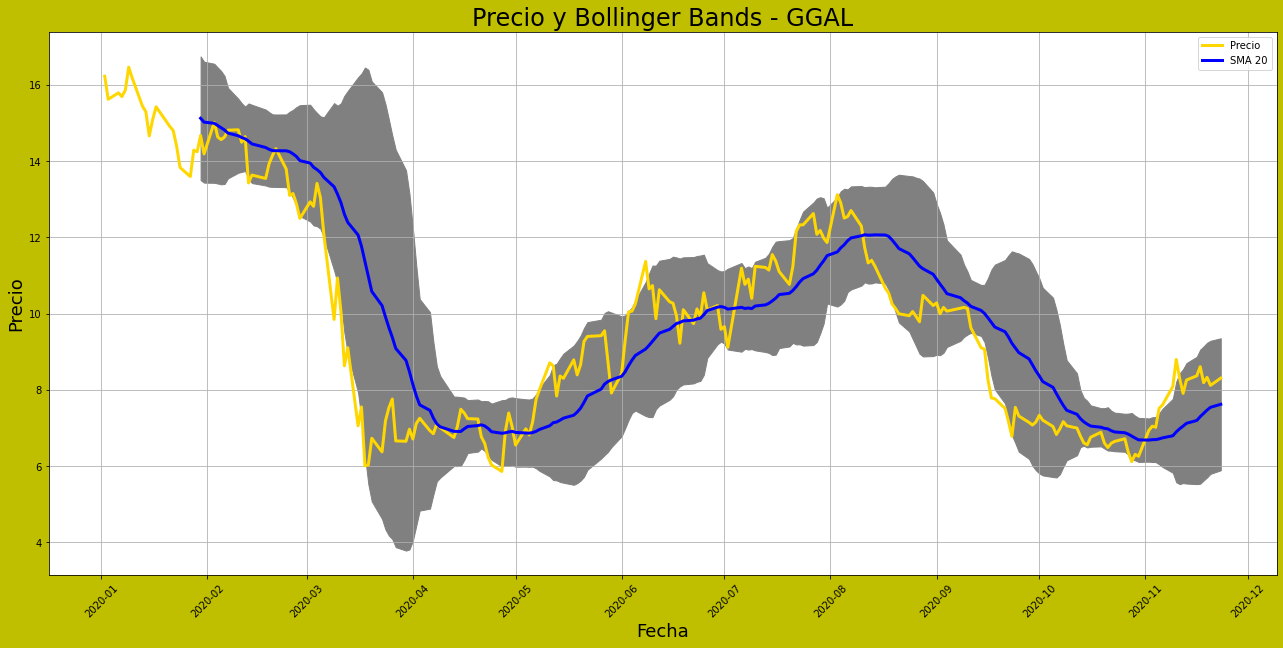

In [258]:
#SHADE THE BOLLINGER AREA and plot it
fig = plt.figure(figsize=(22,10), clear= False, facecolor="y")
ax = fig.add_subplot(1,1,1) #add the subplot
x_axis = df.index #get the date values (index)
ax.fill_between(x_axis,df["Upper"], df["Lower"], color = "grey") #plot and shade the area

#plot the price and SMA

ax.plot(x_axis, df["Close"], label = "Precio", color = "gold", lw = 3)
ax.plot(x_axis, df["SMA"], label = "SMA {}".format(period), color = "blue", lw = 3)

ax.set_title("Precio y Bollinger Bands - {}".format(asset), fontsize = 24)

ax.set_xlabel("Fecha", fontsize = 18)
ax.set_ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
ax.legend(loc = "upper right")
plt.grid(axis ='both')
plt.show()

In [259]:
#Create new df
new_df = df[period -1:]
#new_df

In [260]:
#Get the signals
def get_signal(data):
  buy_signal = []
  sell_signal = []

  for i in range(len(data["Close"])):
    if data["Close"][i] > data["Upper"][i]:
      sell_signal.append(data["Close"][i]) #Hay que vender
      buy_signal.append(np.nan)

    elif data["Close"][i] < data["Lower"][i]:
      buy_signal.append(data["Close"][i]) #Hay que comprar
      sell_signal.append(np.nan)
    else:
      sell_signal.append(np.nan)      
      buy_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [261]:
#Agregar 2 columnas al df
b = get_signal(new_df)
new_df["Buy Bollinger"] = get_signal(new_df)[0]
new_df["Sell Bollinger"] = get_signal(new_df)[1]

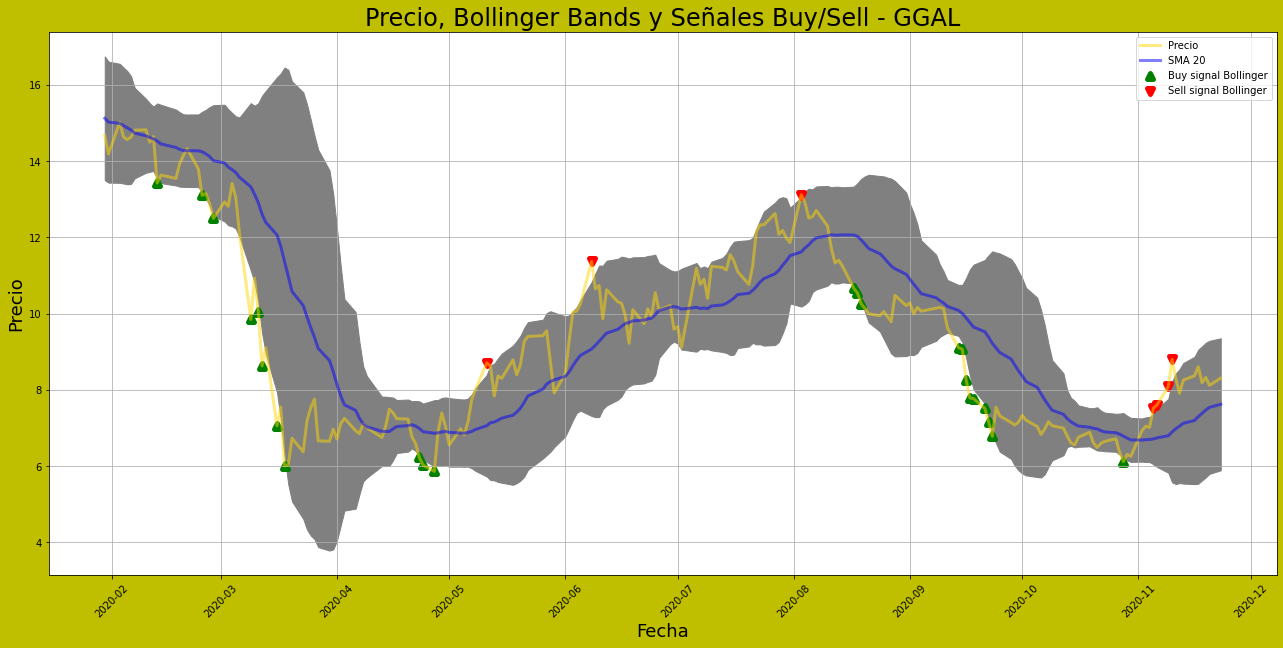

In [262]:
#plot all the data
fig = plt.figure(figsize=(22,10), clear= False, facecolor="y")
ax = fig.add_subplot(1,1,1) #add the subplot
x_axis = new_df.index #get the date values (index)
ax.fill_between(x_axis,new_df["Upper"], new_df["Lower"], color = "grey") #plot and shade the area

#plot the price and SMA
ax.plot(x_axis,new_df["Close"], label = "Precio", color = "gold", lw = 3, alpha = 0.5)
ax.plot(x_axis, new_df["SMA"], label = "SMA {}".format(period), color = "blue", lw = 3, alpha = 0.5)
ax.scatter(x_axis, new_df["Buy Bollinger"], color = "green", marker = "^", alpha = 1, label = "Buy signal Bollinger",lw = 5 )
ax.scatter(x_axis, new_df["Sell Bollinger"], color = "red", marker = "v", alpha = 1, label = "Sell signal Bollinger" , lw = 5)
ax.set_title("Precio, Bollinger Bands y Señales Buy/Sell - {}".format(asset), fontsize = 24)
ax.set_xlabel("Fecha", fontsize = 18)
ax.set_ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
ax.legend(loc = "upper right")
plt.grid(axis ='both')
plt.show()

Estrategia con *Money Flow Index* (MFI)

Link del tuto: https://www.youtube.com/watch?v=tF1Lz4WBQwM

In [263]:
#Get the period
period_MFI = 14

#Calculate the typical price and the  MF
typical_price = (df["Close"] + df["High"] + df["Low"] ) / 3
money_flow = typical_price * df["Volume"]
#money_flow


In [264]:
#Get all the positive and negative money flows
positive_flow =[]
negative_flow =[]

#Loop through the typical price
for i in range(1,len(typical_price)):
  if typical_price[i] > typical_price[i-1]:
    positive_flow.append(money_flow[i-1])
    negative_flow.append(0)
  elif typical_price[i] < typical_price[i-1]:
    negative_flow.append(money_flow[i-1])
    positive_flow.append(0)
  else:
    negative_flow.append(0)
    positive_flow.append(0)

In [265]:
#Get all the positive and negative MF in the time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
  positive_mf.append(sum(positive_flow[i+1-period:i+1]))
for i in range(period-1, len(negative_flow)):
  negative_mf.append(sum(negative_flow[i+1-period:i+1]))



In [266]:
#Calculate the MFI

mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))


In [267]:
new_df_mfi = df[period:]
new_df_mfi["MFI"] = mfi

In [268]:
#Create a function to get mfi buy and sell signal

def get_mfi_signal(data, high, low):
  buy_mfi_signal = []
  sell_mfi_signal = []

  for i in range(len(data["MFI"])):
    if data["MFI"][i] > high:
      buy_mfi_signal.append(np.nan)
      sell_mfi_signal.append(data["Close"][i])
    elif data["MFI"][i] < low:
      sell_mfi_signal.append(np.nan)
      buy_mfi_signal.append(data["Close"][i])
    else:
      buy_mfi_signal.append(np.nan)
      sell_mfi_signal.append(np.nan)
      

  return (buy_mfi_signal, sell_mfi_signal)


In [294]:
#Add columns
high = 75
low = 25

new_df_mfi["Sell MFI"] = get_mfi_signal(new_df_mfi, high, low)[1]
new_df_mfi["Buy MFI"] = get_mfi_signal(new_df_mfi, high = high, low= low)[0]



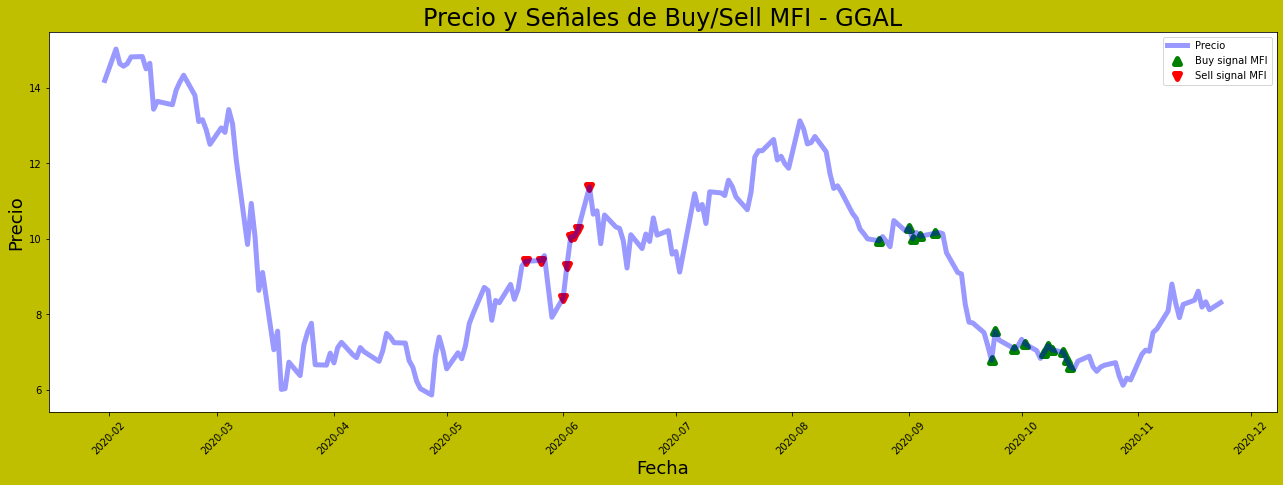

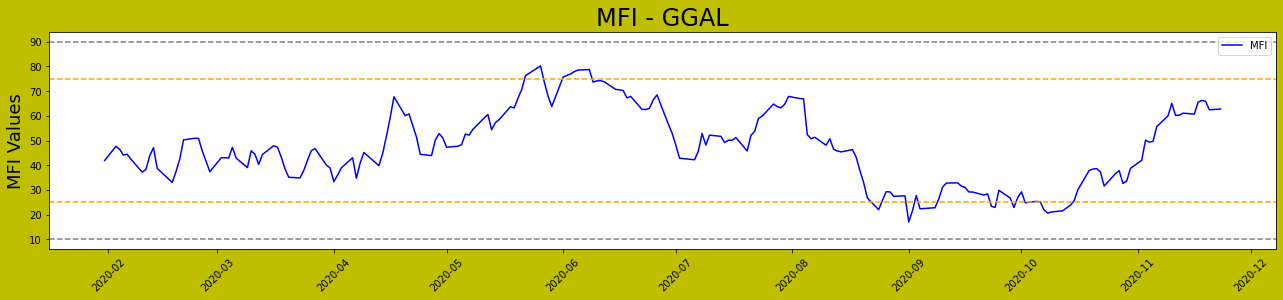

In [295]:
#plot the data
plt.figure(figsize=(22,7), facecolor="y")
plt.title("Precio y Señales de Buy/Sell MFI - {}".format(asset), fontsize = 24)

plt.plot(new_df_mfi["Close"], label = "Precio", color = "blue", alpha = 0.4,lw = 5)
plt.scatter(new_df_mfi.index, new_df_mfi["Buy MFI"], color = "green", marker = "^", alpha = 1, label = "Buy signal MFI",lw = 5 )
plt.scatter(new_df_mfi.index, new_df_mfi["Sell MFI"], color = "red", marker = "v", alpha = 1, label = "Sell signal MFI" , lw = 5)
plt.ylabel("Precio", fontsize = 18)
plt.xlabel("Fecha", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.show()

#MFI plot
plt.figure(figsize=(22,4), facecolor="y")
plt.title("MFI - {}".format(asset), fontsize = 24)
plt.plot(new_df_mfi["MFI"], label = "MFI", color = "blue", alpha = 1)
plt.axhline(low, linestyle = "--", color= "orange")
plt.axhline(high, linestyle = "--", color= "orange")
plt.axhline(10, linestyle = "--", color= "grey")
plt.axhline(90, linestyle = "--", color= "grey")
plt.ylabel("MFI Values", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.show()

**Estrategia Buy de Stan Weinstein (compra/vende con precio sobre/bajo la EMA 30 semanal) **

Aclaración Importante: los cálculos y señales con media exponencial y no ponderada como es la técnica original

In [271]:

weekly = df["Close"].resample("W").last()

In [272]:
#Stan_EMA
Stan_period = 30
Stan_EMA = weekly.ewm(span=Stan_period, adjust = False).mean() 
#Divide by decaying adjustment factor in beginning periods to account for imbalance in relative weightings (viewing EWMA as a moving average).
#When adjust=True (default), the EW function is calculated using weights wi=(1−α)i.

In [273]:
dfw = pd.DataFrame(weekly)
dfw["Stan_EMA"] = Stan_EMA
#dfw

In [274]:
def buy_stan(data):
  buy_list = []
  flag_long = False
  sell_list = []
  flag_short = False

  for i in range(0,len(data)):
    if data["Close"][i] > data["Stan_EMA"][i] and flag_long == False:
      buy_list.append(data["Close"][i])
      sell_list.append(np.nan)
      flag_long = True
      flag_short = False

    elif data["Close"][i] < data["Stan_EMA"][i] and flag_short == False:
      sell_list.append(data["Close"][i])
      buy_list.append(np.nan)
      flag_long = False
      flag_short = True
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  #Esta función también mete las señales en el data set
  data["Buy_Stan"] = buy_list
  data["Sell_Stan"] = sell_list


In [275]:
buy_stan(dfw) #ejecuto la función

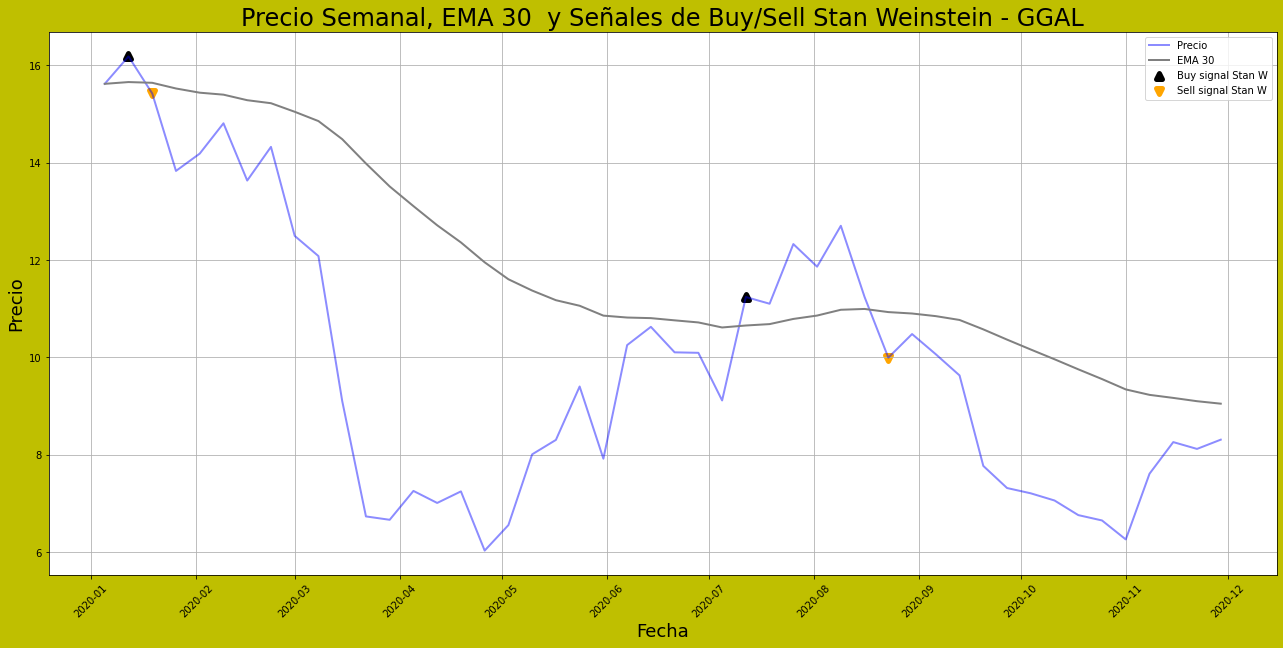

In [276]:
#Gráfico del Close Price, la EMA 30 y las señales
plt.figure(figsize=(22,10), clear= False, facecolor="y")
plt.title("Precio Semanal, EMA {}  y Señales de Buy/Sell Stan Weinstein - {}".format(Stan_period, asset), fontsize = 24)
plt.plot(dfw["Close"], label = "Precio", color = "blue", alpha = 0.45,lw = 2 )
plt.plot(dfw["Stan_EMA"], label = "EMA {}".format(Stan_period), color = "grey", alpha = 1,lw = 2)
plt.scatter(dfw.index, dfw["Buy_Stan"], color = "black", marker = "^", alpha = 1,label = "Buy signal Stan W",lw = 5 )
plt.scatter(dfw.index, dfw["Sell_Stan"], color = "orange", marker = "v", alpha = 1, label = "Sell signal Stan W",lw = 5)
plt.xlabel("Fecha", fontsize = 18)
plt.ylabel("Precio", fontsize = 18)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis ='both')
plt.show(block= True)

Relative Strength Index (RSI)

In [277]:
#Get the difference in price from the previous day
delta = df["Close"].diff(1)
delta = delta.dropna() #sacar en nan


In [278]:
#Create series for the gains (up, positive value) and the loss (down, negative)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0 #deja unicamente las diferencias positivas
down[down > 0] = 0 #deja unicamente las diferencias negativas

RSI_period = 14

#Calculate the average gain and the average loss
AVG_Gain = up.rolling(window = RSI_period).mean()
AVG_Loss = abs(down.rolling(window = RSI_period).mean())

In [279]:
#Calculate the Relavite Strength (RS)
RS = AVG_Gain / AVG_Loss

#Calculate the RSI

RSI = 100.0 - (100.0 / (1.0 + RS))

In [280]:
df["RSI"] = RSI

In [281]:
#Create a function to get rsi buy and sell signal

def get_rsi_signal(data, high, low):
  buy_rsi_signal = []
  sell_rsi_signal = []

  for i in range(len(data["RSI"])):
    if data["RSI"][i] > high:
      buy_rsi_signal.append(np.nan)
      sell_rsi_signal.append(data["Close"][i])
    elif data["RSI"][i] < low:
      sell_rsi_signal.append(np.nan)
      buy_rsi_signal.append(data["Close"][i])
    else:
      buy_rsi_signal.append(np.nan)
      sell_rsi_signal.append(np.nan)
      

  return (buy_rsi_signal, sell_rsi_signal)


In [282]:
#Add columns
high_RSI = 80
low_RSI = 20

df["Sell RSI"] = get_rsi_signal(df, high = high_RSI, low= low_RSI)[1]
df["Buy RSI"] = get_rsi_signal(df, high = high_RSI, low= low_RSI)[0]


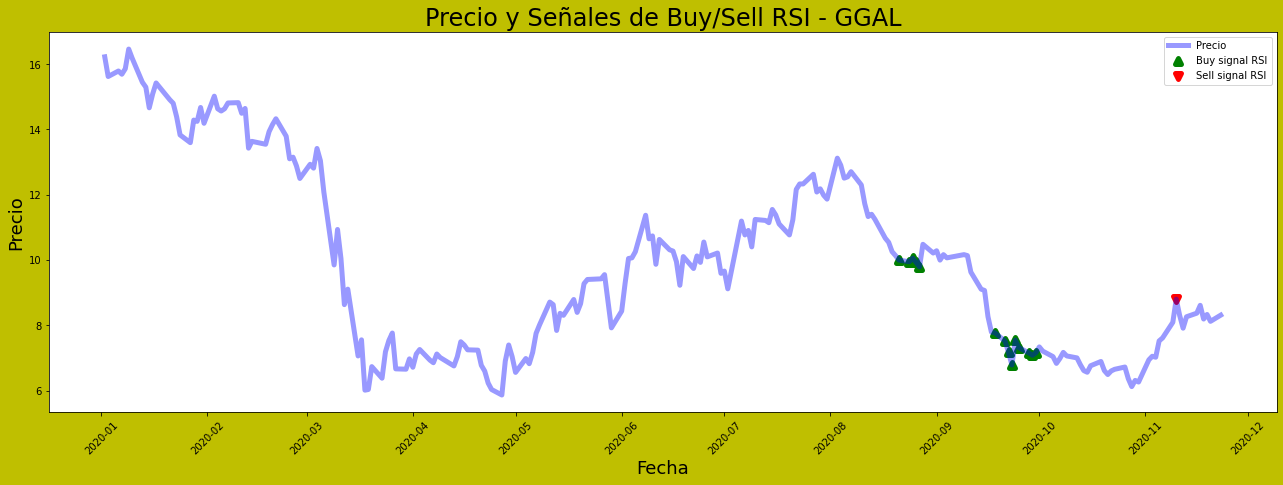

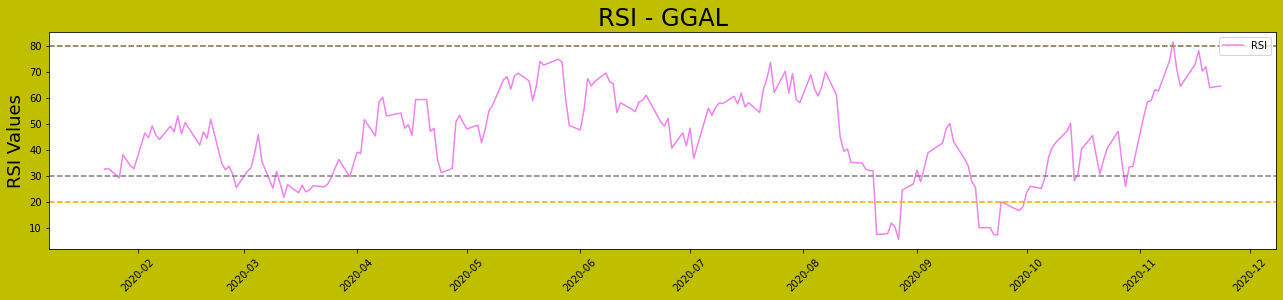

In [283]:
#plot the data
plt.figure(figsize=(22,7), facecolor="y")
plt.title("Precio y Señales de Buy/Sell RSI - {}".format(asset), fontsize = 24)
plt.plot(df["Close"], label = "Precio", color = "blue", alpha = 0.4,lw = 5)
plt.scatter(df.index, df["Buy RSI"], color = "green", marker = "^", alpha = 1, label = "Buy signal RSI",lw = 5 )
plt.scatter(df.index, df["Sell RSI"], color = "red", marker = "v", alpha = 1, label = "Sell signal RSI" , lw = 5)
plt.ylabel("Precio", fontsize = 18)
plt.xlabel("Fecha", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.show()

#MFI plot
plt.figure(figsize=(22,4), facecolor="y")
plt.title("RSI - {}".format(asset), fontsize = 24)
plt.plot(RSI, label = "RSI", color = "violet", alpha = 1)
plt.axhline(low_RSI, linestyle = "--", color= "orange")
plt.axhline(80, linestyle = "--", color= "orange")
plt.axhline(30, linestyle = "--", color= "grey")
plt.axhline(high_RSI, linestyle = "--", color= "grey")
plt.ylabel("RSI Values", fontsize = 18)
plt.xticks(rotation=45)
plt.legend(loc = "upper right")
plt.show()

**Apéndice: Análisis de la Acción**

Estadística Descriptiva

In [284]:
print("Estadística Descriptiva de {}.\nPeríodo: {}".format(asset,period_asset))
df.describe()

Estadística Descriptiva de GGAL.
Período: ytd


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Short,Middle,Long,MA200,Buy,Sell,DEMA_5,DEMA_20,Buy_DEMA,Sell_DEMA,MACD,MACD Signal,Buy Price MACD,Sell Price MACD,SMA,STD,Upper,Lower,RSI,Sell RSI,Buy RSI
count,227.000000,227.000000,227.000000,227.000000,2.270000e+02,227.000000,227.0,227.000000,227.000000,227.000000,28.000000,3.000000,3.000000,227.000000,227.000000,13.000000,12.000000,227.000000,227.000000,9.000000,9.000000,208.000000,208.000000,208.000000,208.000000,213.000000,1.0,14.000000
mean,9.953681,10.270066,9.605601,9.906836,1.397943e+06,0.000361,0.0,9.976985,10.030464,10.257332,9.687168,8.821098,11.992806,9.906555,9.890806,11.341031,11.102985,-0.268273,-0.272392,11.430351,12.196036,9.733744,0.831743,11.397230,8.070257,45.410487,8.8,8.228017
std,2.839508,2.857936,2.804881,2.832349,1.094889e+06,0.005443,0.0,2.838310,2.842583,2.809664,0.312040,2.056488,3.317242,2.846911,3.021378,2.997194,2.559059,0.621303,0.588672,3.423414,2.513286,2.483161,0.525674,2.803290,2.585422,16.777105,NaN,1.347222
min,5.833269,6.317727,5.595983,5.862929,3.323000e+05,0.000000,0.0,6.267205,6.419144,6.760769,9.218582,7.520000,9.115719,5.877428,6.021621,6.901054,6.031007,-2.011008,-1.716145,6.663768,8.433522,6.685500,0.249145,7.252335,3.787607,5.438041,8.8,6.782411
25%,7.301473,7.626455,6.985018,7.222378,8.906000e+05,0.000000,0.0,7.229101,7.347874,7.750751,9.433550,7.635664,10.178560,7.095245,6.870335,10.045087,9.904198,-0.617621,-0.619466,9.283796,9.946218,7.259825,0.485966,8.858724,6.001730,32.692302,8.8,7.160585
50%,9.857236,10.134069,9.422212,9.738593,1.204600e+06,0.000000,0.0,9.883647,9.974018,9.773966,9.644348,7.751327,11.241402,9.755618,10.016881,11.191967,11.374875,-0.333145,-0.330807,10.905247,12.299299,9.656285,0.740759,11.312318,7.425278,46.721312,8.8,7.528872
75%,12.007636,12.338847,11.567669,12.032353,1.660250e+06,0.000000,0.0,11.981427,11.958121,11.833215,9.934536,9.471647,13.431349,12.094851,12.179492,13.416518,12.684888,0.307450,0.290606,14.326113,13.426406,11.372526,0.932783,13.339402,9.396581,58.778627,8.8,9.891840
max,16.629760,16.698968,16.165076,16.461683,1.439150e+07,0.082000,0.0,16.224398,16.224398,16.224398,10.248259,11.191967,15.621297,16.224398,16.224398,16.461683,15.443333,0.739849,0.622901,16.184851,15.621297,15.123492,2.796690,16.745162,13.741483,81.471395,8.8,10.054974


Retornos

In [285]:
print("Retornos Mensuales de {}.\nPeríodo: {}".format(asset,period_asset))
#month = df.Close.resample('M').last()agg(lambda x: (x[-1] / x[1]) - 1)
month3 = df.Close.resample('M').agg(lambda x: x[-1] / x[1] - 1)
month3

Retornos Mensuales de GGAL.
Período: ytd


Date
2020-01-31   -0.091772
2020-02-29   -0.145946
2020-03-31   -0.456019
2020-04-30   -0.011111
2020-05-31    0.134561
2020-06-30    0.033014
2020-07-31    0.301518
2020-08-31   -0.208429
2020-09-30   -0.283877
2020-10-31   -0.131466
2020-11-30    0.178723
Freq: M, Name: Close, dtype: float64

Precios Promedio

In [286]:
print("Precios Promedio Mensuales de {}.\nPeríodo: {}".format(asset,period_asset))
monthly_avg = df["Close"].resample("M").mean()
monthly_avg

Precios Promedio Mensuales de GGAL.
Período: ytd


Date
2020-01-31    15.078930
2020-02-29    14.002447
2020-03-31     8.881130
2020-04-30     6.904349
2020-05-31     8.263963
2020-06-30    10.064861
2020-07-31    11.328137
2020-08-31    11.132175
2020-09-30     8.585122
2020-10-31     6.743322
2020-11-30     7.964375
Freq: M, Name: Close, dtype: float64

Desvío Estándar

In [287]:
print("Desvío Estándar Mensual de {} (En %).\nPeríodo: {}".format(asset,period_asset))
monthly_std = df["Close"].resample("M").std()*100
monthly_std

Desvío Estándar Mensual de GGAL (En %).
Período: ytd


Date
2020-01-31     81.626091
2020-02-29     74.640675
2020-03-31    256.720142
2020-04-30     43.602599
2020-05-31     88.266462
2020-06-30     60.147388
2020-07-31     87.078993
2020-08-31    114.040318
2020-09-30    132.913265
2020-10-31     32.432637
2020-11-30     57.311973
Freq: M, Name: Close, dtype: float64

In [288]:
print("Desvío Estándar Semanal de {} (En %).\nPeríodo: {}".format(asset,period_asset))
weekly_std = df["Close"].resample("W").std()*100
weekly_std.dropna(inplace=True)
weekly_std

Desvío Estándar Semanal de GGAL (En %).
Período: ytd


Date
2020-01-05    42.645665
2020-01-12    31.914932
2020-01-19    32.345434
2020-01-26    48.866872
2020-02-02    38.710716
2020-02-09    18.456971
2020-02-16    62.968725
2020-02-23    33.638480
2020-03-01    47.202001
2020-03-08    48.870645
2020-03-15    88.884823
2020-03-22    66.674643
2020-03-29    58.007529
2020-04-05    25.814080
2020-04-12    11.398558
2020-04-19    29.655742
2020-04-26    47.268259
2020-05-03    58.053016
2020-05-10    51.068496
2020-05-17    34.239243
2020-05-24    42.355874
2020-05-31    74.977074
2020-06-07    75.822263
2020-06-14    53.368190
2020-06-21    44.240958
2020-06-28    30.097429
2020-07-05    44.950057
2020-07-12    34.224951
2020-07-19    18.478189
2020-07-26    72.002838
2020-08-02    29.209061
2020-08-09    25.614533
2020-08-16    43.194529
2020-08-23    27.995798
2020-08-30    26.414903
2020-09-06    11.466244
2020-09-13    25.900107
2020-09-20    65.703624
2020-09-27    31.009254
2020-10-04     9.570401
2020-10-11    12.327725
2020-10-18 

Precios Máximos y Mínimos

In [289]:
print("Máximo Mensual de {} (En $).\nPeríodo: {}".format(asset,period_asset))
monthly_max = df["Close"].resample("M").max()
monthly_max

Máximo Mensual de GGAL (En $).
Período: ytd


Date
2020-01-31    16.461683
2020-02-29    15.018195
2020-03-31    13.416518
2020-04-30     7.494267
2020-05-31     9.550742
2020-06-30    11.369931
2020-07-31    12.625567
2020-08-31    13.119912
2020-09-30    10.282372
2020-10-31     7.336077
2020-11-30     8.800000
Freq: M, Name: Close, dtype: float64

In [290]:
print("Mínimo Mensual de {} (En $).\nPeríodo: {}".format(asset,period_asset))
monthly_min = df["Close"].resample("M").min()
monthly_min

Mínimo Mensual de GGAL (En $).
Período: ytd


Date
2020-01-31    13.594482
2020-02-29    12.497038
2020-03-31     6.011233
2020-04-30     5.862929
2020-05-31     6.555013
2020-06-30     8.433522
2020-07-31     9.115719
2020-08-31     9.788027
2020-09-30     6.782411
2020-10-31     6.120000
2020-11-30     6.940000
Freq: M, Name: Close, dtype: float64

In [291]:
print("Mínimo Semanal de {} (En $).\nPeríodo: {}".format(asset,period_asset))
weekly_min = df["Close"].resample("W").min()
weekly_min

Mínimo Semanal de GGAL (En $).
Período: ytd


Date
2020-01-05    15.621297
2020-01-12    15.690505
2020-01-19    14.662268
2020-01-26    13.831768
2020-02-02    13.594482
2020-02-09    14.563398
2020-02-16    13.426406
2020-02-23    13.545048
2020-03-01    12.497038
2020-03-08    12.081788
2020-03-15     8.631260
2020-03-22     6.011233
2020-03-29     6.377048
2020-04-05     6.653882
2020-04-12     6.851619
2020-04-19     6.752750
2020-04-26     6.031007
2020-05-03     5.862929
2020-05-10     6.821959
2020-05-17     7.840309
2020-05-24     8.393975
2020-05-31     7.919405
2020-06-07     8.433522
2020-06-14     9.867123
2020-06-21     9.224475
2020-06-28     9.738593
2020-07-05     9.115719
2020-07-12    10.401015
2020-07-19    11.102984
2020-07-26    10.766830
2020-08-02    11.864276
2020-08-09    12.506924
2020-08-16    11.241402
2020-08-23     9.995652
2020-08-30     9.788027
2020-09-06     9.995652
2020-09-13     9.629837
2020-09-20     7.771101
2020-09-27     6.782411
2020-10-04     7.079018
2020-10-11     6.831845
2020-10-18 